In [1]:
import pandas as pd
import json
import os
import base64
import io
from shapely.geometry import LineString, box
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import contextily as ctx
from io import BytesIO
from pyproj import Transformer
from shapely.geometry import LineString, box
from datetime import datetime

In [2]:
def extract_coordinates_from_plt(plt_file):
    """
    Extracts latitude and longitude coordinates from a .plt file.

    Args:
        plt_file (str): Path to the .plt file.

    Returns:
        list: A list of [longitude, latitude] coordinates.
    """
    coordinates = []

    try:
        with open(plt_file, 'r') as file:
            lines = file.readlines()

            # Skip the header lines that are not relevant
            for line in lines[8:]:  # Skipping the first 8 lines of metadata
                parts = line.split(',')
                if len(parts) >= 2:
                    try:
                        latitude = float(parts[0].strip())
                        longitude = float(parts[1].strip())
                        coordinates.append([longitude, latitude])  # [longitude, latitude]
                    except ValueError:
                        print(f"Invalid coordinate in line: {line.strip()}")
    except FileNotFoundError:
        print(f"File not found: {plt_file}")

    return coordinates

def create_excel_with_polylines(plt_files, excel_file, row_limit=900):
    """
    Creates or appends to an Excel file, ensuring each row has a maximum of `row_limit` coordinates.

    Args:
        plt_files (list): List of .plt file paths.
        excel_file (str): Path to the Excel file to create or append to.
        row_limit (int): Maximum number of coordinates per row.
    """
    # List to store all the data for the Excel file
    data = []

    # Process each .plt file
    for plt_file in plt_files:
        coordinates = extract_coordinates_from_plt(plt_file)

        # Split coordinates into chunks of size `row_limit`
        for i in range(0, len(coordinates), row_limit):
            chunk = coordinates[i:i + row_limit]
            data.append({"FILE_NAME": os.path.basename(plt_file), "POLYLINE": json.dumps(chunk)})

    if not data:
        print("No valid data to write to Excel.")
        return

    # Check if the Excel file already exists
    if os.path.exists(excel_file):
        # Load existing data and append new rows
        df_existing = pd.read_excel(excel_file)
        df_new = pd.DataFrame(data)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        df_combined.to_excel(excel_file, index=False)
    else:
        # Create a new Excel file with the data
        df = pd.DataFrame(data)
        df.to_excel(excel_file, index=False)

    print(f"Data successfully written to {excel_file}")

In [3]:
def extract_coordinates_with_hour(plt_file):
    """
    Extracts latitude, longitude, and hour information from a .plt file.
    Groups coordinates by hour.

    Args:
        plt_file (str): Path to the .plt file.

    Returns:
        dict: Dictionary where keys are hours and values are lists of coordinates.
    """
    grouped_coordinates = {}

    with open(plt_file, 'r') as file:
        lines = file.readlines()

        # Skip the header lines that are not relevant
        for index, line in enumerate(lines[8:], start=9):  # Skipping the first 8 lines of metadata
            parts = line.strip().split(',')
            if len(parts) >= 7:  # Ensure there are enough parts
                try:
                    latitude = float(parts[0].strip())
                    longitude = float(parts[1].strip())
                    date_part = parts[5].strip()
                    time_part = parts[6].strip()

                    # Combine date and time and parse as a datetime object
                    datetime_str = f"{date_part} {time_part}"
                    hour = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d %H")

                    # Group coordinates by hour
                    if hour not in grouped_coordinates:
                        grouped_coordinates[hour] = []
                    grouped_coordinates[hour].append([longitude, latitude])
                except (ValueError, IndexError) as e:
                    # Skip lines with invalid data and log the error
                    print(f"Skipping invalid line {index}: {line.strip()} (Error: {e})")
                    continue

    return grouped_coordinates

def create_excel_grouped_by_hour(plt_files, excel_file):
    """
    Creates or appends to an Excel file, grouping coordinates by the hour.

    Args:
        plt_files (list): List of .plt file paths.
        excel_file (str): Path to the Excel file to create or append to.
    """
    # List to store all the data for the Excel file
    data = []

    # Process each .plt file
    for plt_file in plt_files:
        if not os.path.exists(plt_file):
            print(f"File not found: {plt_file}")
            continue

        grouped_coordinates = extract_coordinates_with_hour(plt_file)

        # Add each group of coordinates to the data list
        for hour, coordinates in grouped_coordinates.items():
            data.append({
                "FILE_NAME": os.path.basename(plt_file),
                "HOUR": hour,
                "POLYLINE": json.dumps(coordinates)
            })

    if not data:
        print("No valid data to write to Excel. Please check your .plt files.")
        return

    # Check if the Excel file already exists
    if os.path.exists(excel_file):
        # Load existing data and append new rows
        df_existing = pd.read_excel(excel_file)
        df_new = pd.DataFrame(data)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        df_combined.to_excel(excel_file, index=False)
    else:
        # Create a new Excel file with the data
        df = pd.DataFrame(data)
        df.to_excel(excel_file, index=False)

    print(f"Data successfully written to {excel_file}")


In [4]:
""" def extract_coordinates_from_plt(plt_file):
    
    Extracts latitude and longitude coordinates from a .plt file.
    The .plt file must contain lines in the format:
    latitude,longitude,altitude,timestamp
    
    coordinates = []

    with open(plt_file, 'r') as file:
        lines = file.readlines()

        # Skip the header lines that are not relevant
        for line in lines[8:]:  # Skipping the first 8 lines of metadata
            parts = line.split(',')
            if len(parts) >= 2:
                latitude = float(parts[0].strip())
                longitude = float(parts[1].strip())
                coordinates.append([longitude, latitude])  # [longitude, latitude]

    return coordinates """

" def extract_coordinates_from_plt(plt_file):\n    \n    Extracts latitude and longitude coordinates from a .plt file.\n    The .plt file must contain lines in the format:\n    latitude,longitude,altitude,timestamp\n    \n    coordinates = []\n\n    with open(plt_file, 'r') as file:\n        lines = file.readlines()\n\n        # Skip the header lines that are not relevant\n        for line in lines[8:]:  # Skipping the first 8 lines of metadata\n            parts = line.split(',')\n            if len(parts) >= 2:\n                latitude = float(parts[0].strip())\n                longitude = float(parts[1].strip())\n                coordinates.append([longitude, latitude])  # [longitude, latitude]\n\n    return coordinates "

In [5]:
""" def create_excel_with_polylines(plt_files, excel_file):
    
    Creates or appends to an Excel file, where each row corresponds to a .plt file
    with a list of latitudes and longitudes in the 'POLYLINE' column.
    
    # List to store all the data for the Excel file
    data = []
    
    # Collect data from each .plt file
    for plt_file in plt_files:
        coordinates = extract_coordinates_from_plt(plt_file)
        # Append the data as a JSON string
        data.append({"POLYLINE": json.dumps(coordinates)})
    
    # Check if the Excel file already exists
    if os.path.exists(excel_file):
        # If it exists, load the existing Excel file and append the new data
        df_existing = pd.read_excel(excel_file)
        # Append the new data as a DataFrame
        df_new = pd.DataFrame(data)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        df_combined.to_excel(excel_file, index=False)  # Save back to the Excel file
    else:
        # If it doesn't exist, create a new Excel file with the data
        df = pd.DataFrame(data)
        df.to_excel(excel_file, index=False)  # Save to the Excel file
 """

' def create_excel_with_polylines(plt_files, excel_file):\n    \n    Creates or appends to an Excel file, where each row corresponds to a .plt file\n    with a list of latitudes and longitudes in the \'POLYLINE\' column.\n    \n    # List to store all the data for the Excel file\n    data = []\n    \n    # Collect data from each .plt file\n    for plt_file in plt_files:\n        coordinates = extract_coordinates_from_plt(plt_file)\n        # Append the data as a JSON string\n        data.append({"POLYLINE": json.dumps(coordinates)})\n    \n    # Check if the Excel file already exists\n    if os.path.exists(excel_file):\n        # If it exists, load the existing Excel file and append the new data\n        df_existing = pd.read_excel(excel_file)\n        # Append the new data as a DataFrame\n        df_new = pd.DataFrame(data)\n        df_combined = pd.concat([df_existing, df_new], ignore_index=True)\n        df_combined.to_excel(excel_file, index=False)  # Save back to the Excel file\n 

In [6]:
plt_folder = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/code/app/train_data/taxis_trajectory/Geolife Trajectories 1.3/Data/000/Trajectory"

plt_files = [os.path.join(plt_folder, f) for f in os.listdir(plt_folder) if f.endswith('.plt')]

In [7]:
excel_file = 'polylines.xlsx'

create_excel_grouped_by_hour(plt_files=plt_files, excel_file=excel_file)

Data successfully written to polylines.xlsx


In [8]:
def load_and_simplify_data(filepath, rows, tolerance=0.001):
    """
    Loads and simplifies data from a file, either CSV or Excel, and prepares it for processing.

    Parameters:
    - filename: str, the uploaded file containing trajectory data.
    - rows: int, the maximum number of rows to load.
    - tolerance: float, the tolerance value used to simplify geometries.

    Returns:
    - gdf: GeoDataFrame, geospatial data with simplified geometries.
    - trayectorias: list, a list of numpy arrays representing trajectories.
    - df: DataFrame, original data with converted geometries and filtered rows.
    """
    try:
        # Decode the base64-encoded file content
        # _, content_string = filename.split(',')
        # decoded = base64.b64decode(content_string)

        # Load data as DataFrame based on file type
        if filepath.endswith('.csv'):
            df = pd.read_csv(filepath, nrows=rows)
        elif filepath.endswith('.xlsx'):
            df = pd.read_excel(filepath, nrows=rows)
        else:
            raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")

        print(df)


        # Convert the POLYLINE column to geometries
        def create_line(x):
            points = json.loads(x)
            if len(points) > 1:
                return LineString(points)
            return None

        # Apply geometry transformation and filter invalid rows
        df['geometry'] = df['POLYLINE'].apply(create_line)
        df = df[df['geometry'].notnull()]
        gdf = gpd.GeoDataFrame(df, geometry='geometry')

        # Simplify geometries based on the tolerance value
        gdf['geometry'] = gdf['geometry'].simplify(tolerance)

        # Convert POLYLINE JSON strings to lists and filter invalid entries
        df['POLYLINE'] = df['POLYLINE'].apply(lambda x: json.loads(x) if pd.notnull(x) else None)
        df = df[df['POLYLINE'].apply(lambda x: x is not None and len(x) > 0)]

        # Prepare trajectories for TRACLUS processing
        trayectorias = [np.array(polyline) for polyline in df['POLYLINE']]

        return gdf, trayectorias, df

    except Exception as e:
        # Handle errors in data loading
        print(f"Error loading and simplifying data: {e}")
        raise e

In [9]:
def filter_data_in_area(gdf, minx, miny, maxx, maxy):
    """
    Filter GeoDataFrame to include geometries within a specified area.

    Args:
        gdf (GeoDataFrame): Input GeoDataFrame.
        minx, miny, maxx, maxy (float): Coordinates defining the area.

    Returns:
        GeoDataFrame: Filtered GeoDataFrame.
    """
    area_of_interest = box(minx, miny, maxx, maxy)
    gdf_filtered = gdf[gdf.geometry.within(area_of_interest)]
    return gdf_filtered

In [10]:
def list_coordinates(gdf):
    """
    Extract x and y coordinates from a GeoDataFrame's LineString geometries.

    Args:
        gdf (GeoDataFrame): Input GeoDataFrame containing LineString geometries.

    Returns:
        tuple: Two lists containing x and y coordinates respectively.
    """
    x_coords_flat = []
    y_coords_flat = []

    for geom in gdf['geometry']:
        if isinstance(geom, LineString):
            for point in geom.coords:
                x_coords_flat.append(point[0])
                y_coords_flat.append(point[1])

    return x_coords_flat, y_coords_flat

In [11]:
def get_coordinates(gdf):
    """
    Get the minimum and maximum x and y coordinates from a GeoDataFrame.

    Args:
        gdf (GeoDataFrame): Input GeoDataFrame containing geometry.

    Returns:
        tuple: (minx, miny, maxx, maxy) - minimum and maximum coordinates.
    """
    x_coords_flat, y_coords_flat = list_coordinates(gdf)
    maxx, maxy, minx, miny = max(x_coords_flat), max(y_coords_flat), min(x_coords_flat), min(y_coords_flat)
    return minx, miny, maxx, maxy

In [12]:
def map_ilustration(gdf, minx, miny, maxx, maxy):
    """
    Create a map with trajectories overlaid on a base map.

    Args:
        gdf (GeoDataFrame): Input GeoDataFrame with trajectories.
        minx, miny, maxx, maxy (float): Coordinates for filtering data.

    Returns:
        BytesIO: Image data of the generated map.
    """
    gdf = gdf.set_crs("EPSG:4326")
    gdf = filter_data_in_area(gdf, minx, miny, maxx, maxy)
    gdf = gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    gdf.plot(ax=ax, linewidth=0.5, color='green')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    plt.title('Map of Trajectories with Background Map')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.show()

    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)
    plt.close(fig)

    
    

In [13]:
def create_gdf(data):
    """
    Create a GeoDataFrame from a list of trajectory data.

    Args:
        data (list): List of trajectory data.

    Returns:
        GeoDataFrame: GeoDataFrame containing LineString geometries.
    """
    valid_geometries = [LineString(x) for x in data if len(x) > 1]
    gdf = gpd.GeoDataFrame(geometry=valid_geometries, crs='EPSG:4326')
    return gdf

def plot_map_traclus(representative_clusters, cmap='tab20'):
    """
    Plot TRACLUS representative trajectories on a map.

    Args:
        representative_clusters (list): List of representative trajectories.
        cmap (str): Colormap for clusters.

    Returns:
        BytesIO: Image data of the plotted map.
    """
    gdf = create_gdf(representative_clusters)
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    gdf.plot(ax=ax, cmap=cmap, linewidth=2)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())

    plt.title('Representation of TRACLUS Trajectories')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.show()

    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)
    plt.close(fig)

In [14]:
file = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/code/Research and experiments/Data transformation/polylines.xlsx"

gdf, tray, df = load_and_simplify_data(file, rows=50)

             FILE_NAME           HOUR  \
0   20081023025304.plt  2008-10-23 02   
1   20081023025304.plt  2008-10-23 03   
2   20081023025304.plt  2008-10-23 04   
3   20081023025304.plt  2008-10-23 09   
4   20081023025304.plt  2008-10-23 10   
5   20081023025304.plt  2008-10-23 11   
6   20081024020959.plt  2008-10-24 02   
7   20081026134407.plt  2008-10-26 13   
8   20081026134407.plt  2008-10-26 14   
9   20081026134407.plt  2008-10-26 15   
10  20081027115449.plt  2008-10-27 11   
11  20081027115449.plt  2008-10-27 12   
12  20081028003826.plt  2008-10-28 00   
13  20081028003826.plt  2008-10-28 01   
14  20081028003826.plt  2008-10-28 02   
15  20081028003826.plt  2008-10-28 05   
16  20081029092138.plt  2008-10-29 09   
17  20081029093038.plt  2008-10-29 09   
18  20081103101336.plt  2008-11-03 10   
19  20081103232153.plt  2008-11-03 23   
20  20081103232153.plt  2008-11-04 00   
21  20081103232153.plt  2008-11-04 01   
22  20081103232153.plt  2008-11-04 02   
23  200811032321

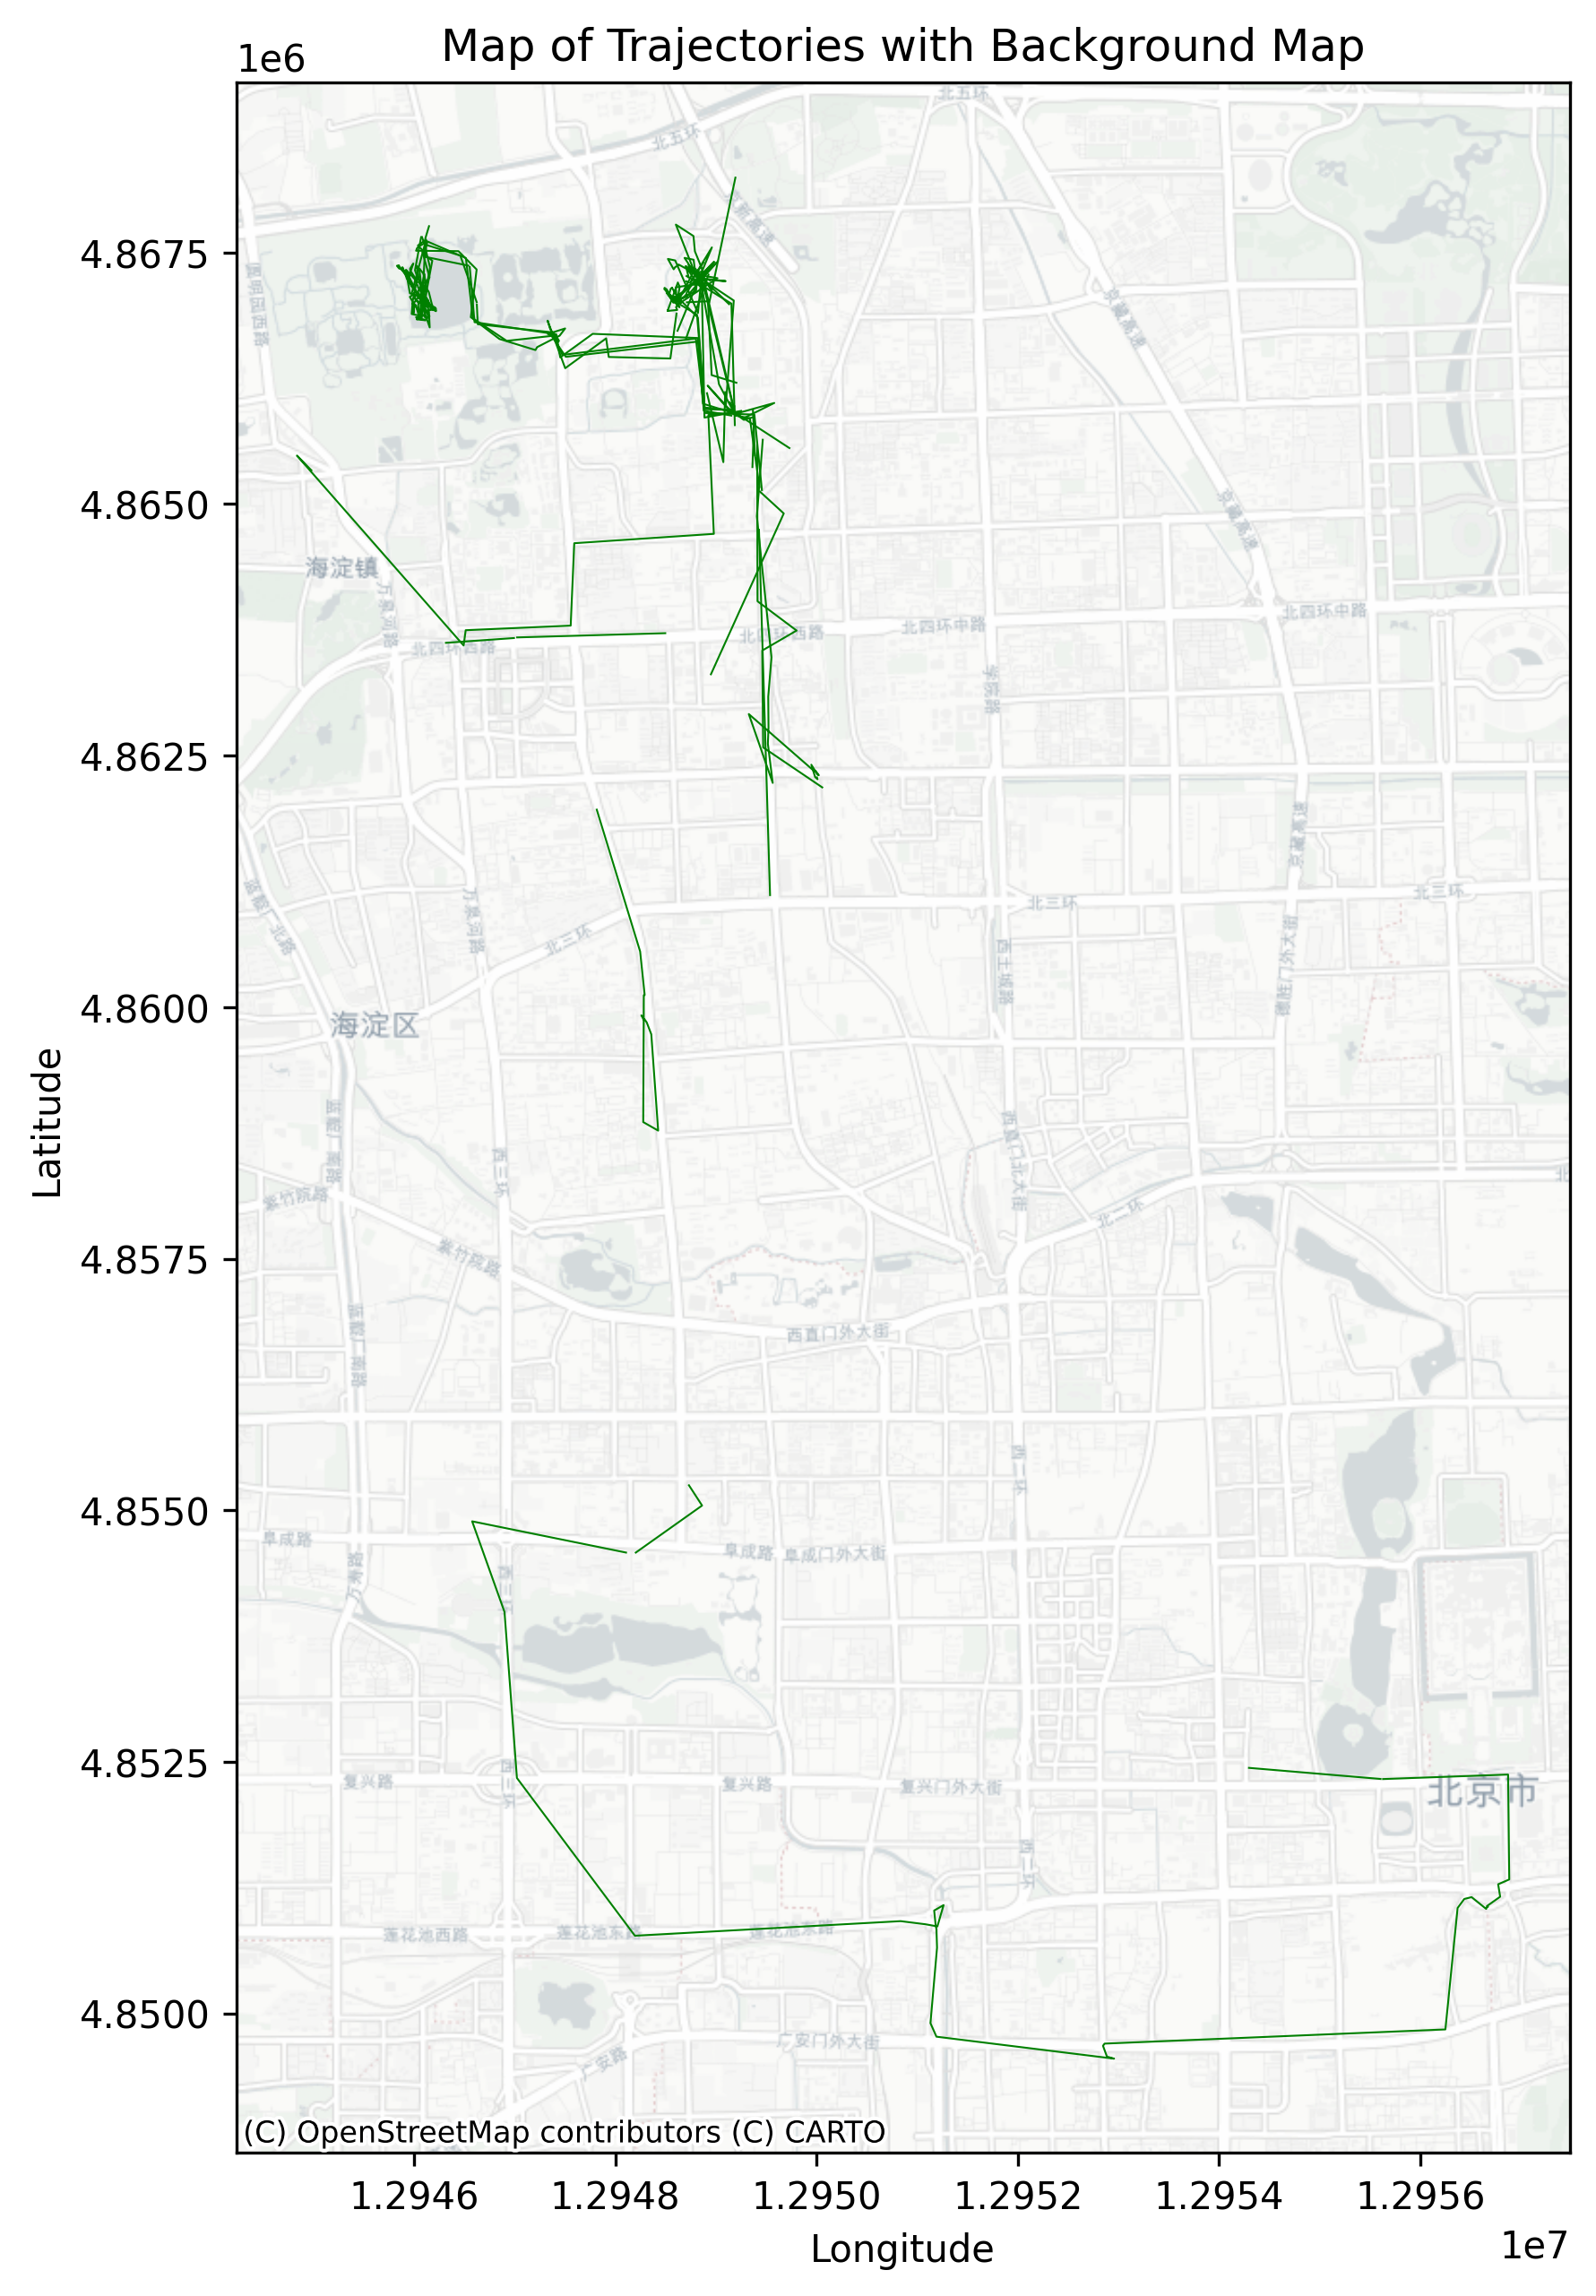

<Figure size 640x480 with 0 Axes>

In [15]:
map_ilustration(gdf, *get_coordinates(gdf))

In [16]:
from TRACLUS_2 import traclus as tr
from sklearn.cluster import OPTICS

In [25]:
result = tr(trajectories = tray, clustering_algorithm=OPTICS, optics_min_samples=0.01, optics_max_eps=50, optics_metric="euclidean", optics_algorithm="auto")

c:\Users\Álvaro\Documents\GitHub\TFG\TFG_TRACLUS\code\Research and experiments\Data transformation\TRACLUS_2.py:297: RuntimeWarning: divide by zero encountered in scalar divide
  tan_theta0 = (shorter_slope - longer_slope) / (1 + shorter_slope * longer_slope)


Angular time:  57.46328401565552
Perpendicular time:  209.40112257003784
Parallel time:  336.59758734703064


In [26]:
_, segments, _, clusters, cluster_assignments, representative_trajectories = result

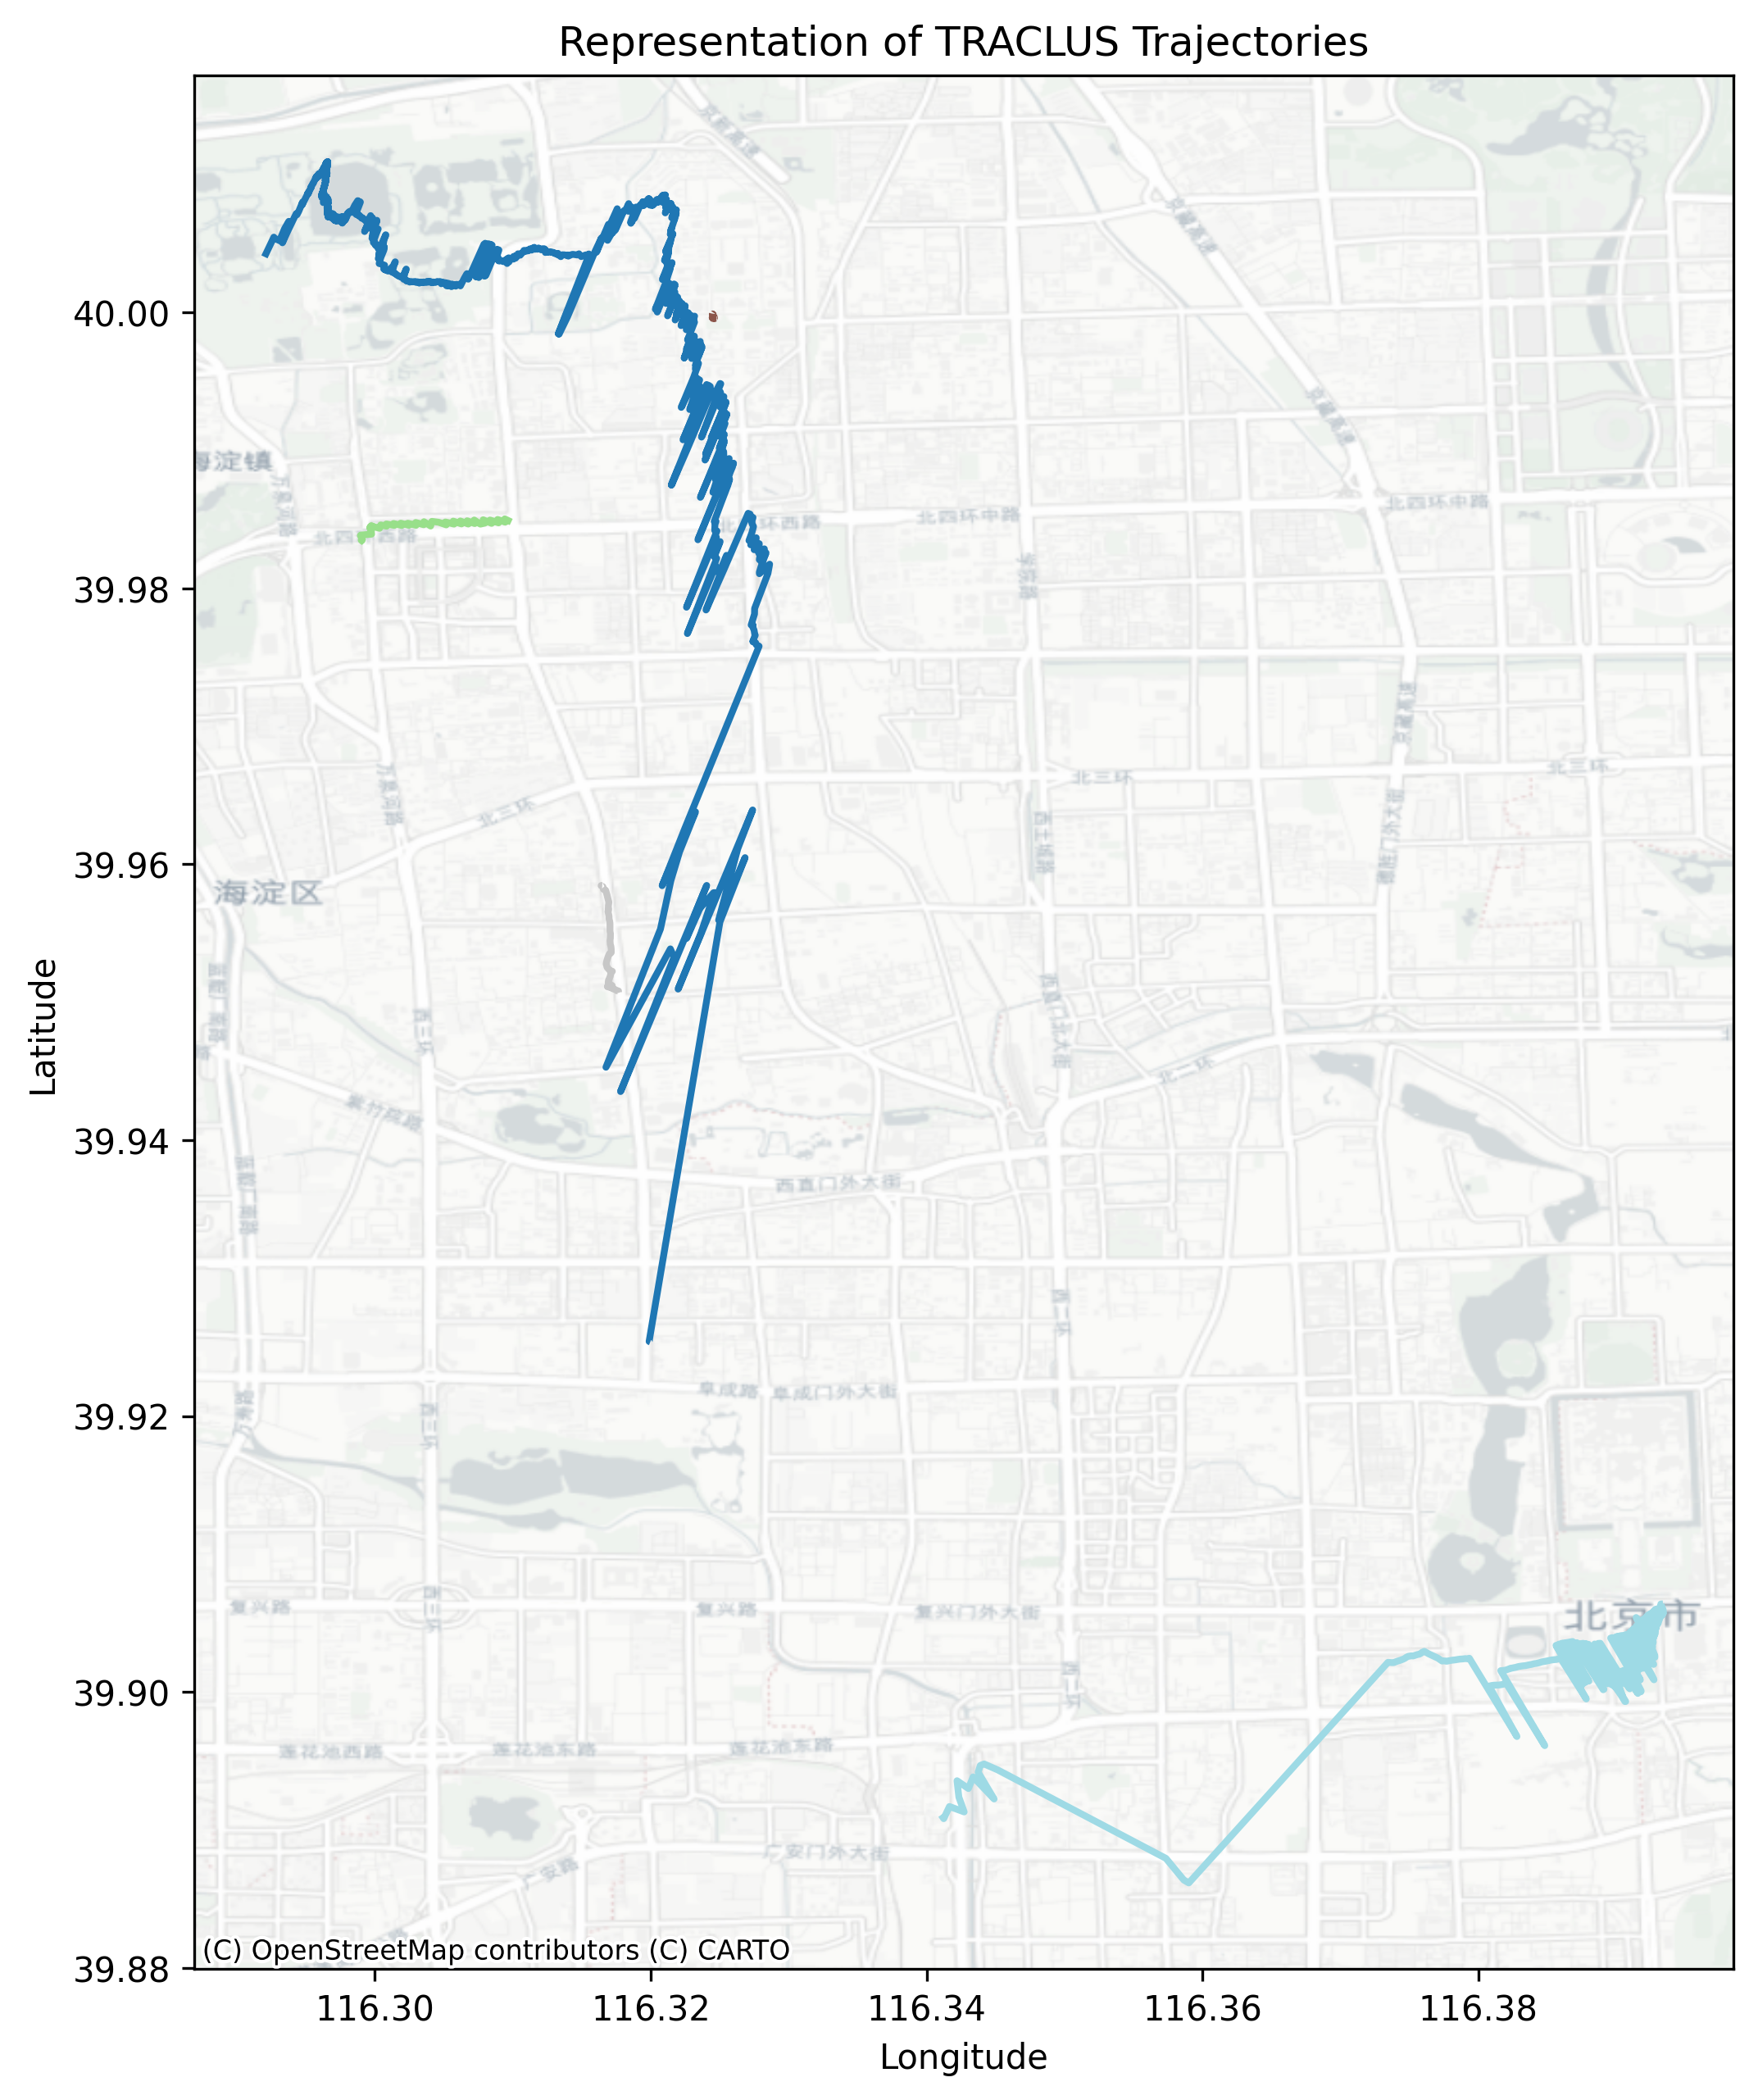

<Figure size 640x480 with 0 Axes>

In [27]:
plot_map_traclus(representative_clusters=representative_trajectories)

In [28]:
representative_trajectories

[array([[116.29199031,  40.00404145],
        [116.29199031,  40.00404145],
        [116.29267173,  40.00547031],
        ...,
        [116.31987999,  39.92540839],
        [116.31987999,  39.92540839],
        [116.31996407,  39.92537364]]),
 array([[116.29921301,  39.98334539],
        [116.29921301,  39.98334539],
        [116.29900217,  39.98349978],
        [116.29900217,  39.98349978],
        [116.29906033,  39.98347186],
        [116.29906033,  39.98347186],
        [116.29907055,  39.9835461 ],
        [116.29907055,  39.9835461 ],
        [116.29905826,  39.98365653],
        [116.29905826,  39.98365653],
        [116.29894539,  39.98382768],
        [116.29905682,  39.98379153],
        [116.29905682,  39.98379153],
        [116.2989798 ,  39.98387238],
        [116.2989798 ,  39.98387238],
        [116.2997596 ,  39.98393748],
        [116.2997596 ,  39.98393748],
        [116.29973409,  39.98415155],
        [116.29974142,  39.98419017],
        [116.29974142,  39.98419017